# Fine-tuning : RF-DETR

Objectif : faire de RF-DETR un détecteur de poissons sur des images de 1920\*1080 pixels

In [1]:
# Importations
import os
import numpy as np
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import json
import cv2
import matplotlib.pyplot as plt
import pycocotools.coco as coco
from PIL import Image
from rfdetr import RFDETRLarge, RFDETRBase  # Assurez-vous que le package rf-detr est bien installé


# Vérification de la disponibilité du GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device utilisé :", device)


Device utilisé : cuda


In [2]:
data_dir = "/home/mateo/Travail/Fine-tune/Dataset/Roboflow"  # chemin vers votre jeu de données
#images_dir = os.path.join(data_dir, "luderick-seagrass/train")
#annotations_file = os.path.join(images_dir, "_annotations.coco.json")

# Charger les annotations COCO
#coco_dataset = coco.COCO(annotations_file)
#print("Nombre d'images dans le dataset :", len(coco_dataset.imgs))


In [3]:
# Cellule 6 : Charger et adapter le modèle rf-detr pré-entraîné
# -----------------------------------------------------
# Nous allons charger le modèle rf-detr du dépôt et le fine-tuner
# Vous pouvez soit utiliser le modèle préentraîné fourni par rf-detr (si disponible) ou initialiser un modèle de DETR et le charger
# Vous pouvez adapter le nombre de classes. Ici, nous avons 1 classe (poisson) + 1 classe pour le fond si nécessaire.
num_classes = 1  # par exemple, 1 classe pour "poisson" et 1 classe pour le "fond"

# Chargement du modèle pré-entraîné (précisez éventuellement le checkpoint préentraîné)
model = RFDETRBase(num_classes=num_classes, pretrained=True)
#model.to(device)
print("Modèle chargé sur l'appareil :", device)


num_classes mismatch: pretrain weights has 90 classes, but your model has 1 classes
reinitializing detection head with 90 classes


Loading pretrain weights
Modèle chargé sur l'appareil : cuda


In [4]:
#model.train(dataset_dir=os.path.join(data_dir, "Fish.v44i.coco"), epochs=3, batch_size=1, grad_accum_steps=1, lr=1e-4, tensorboard=True)

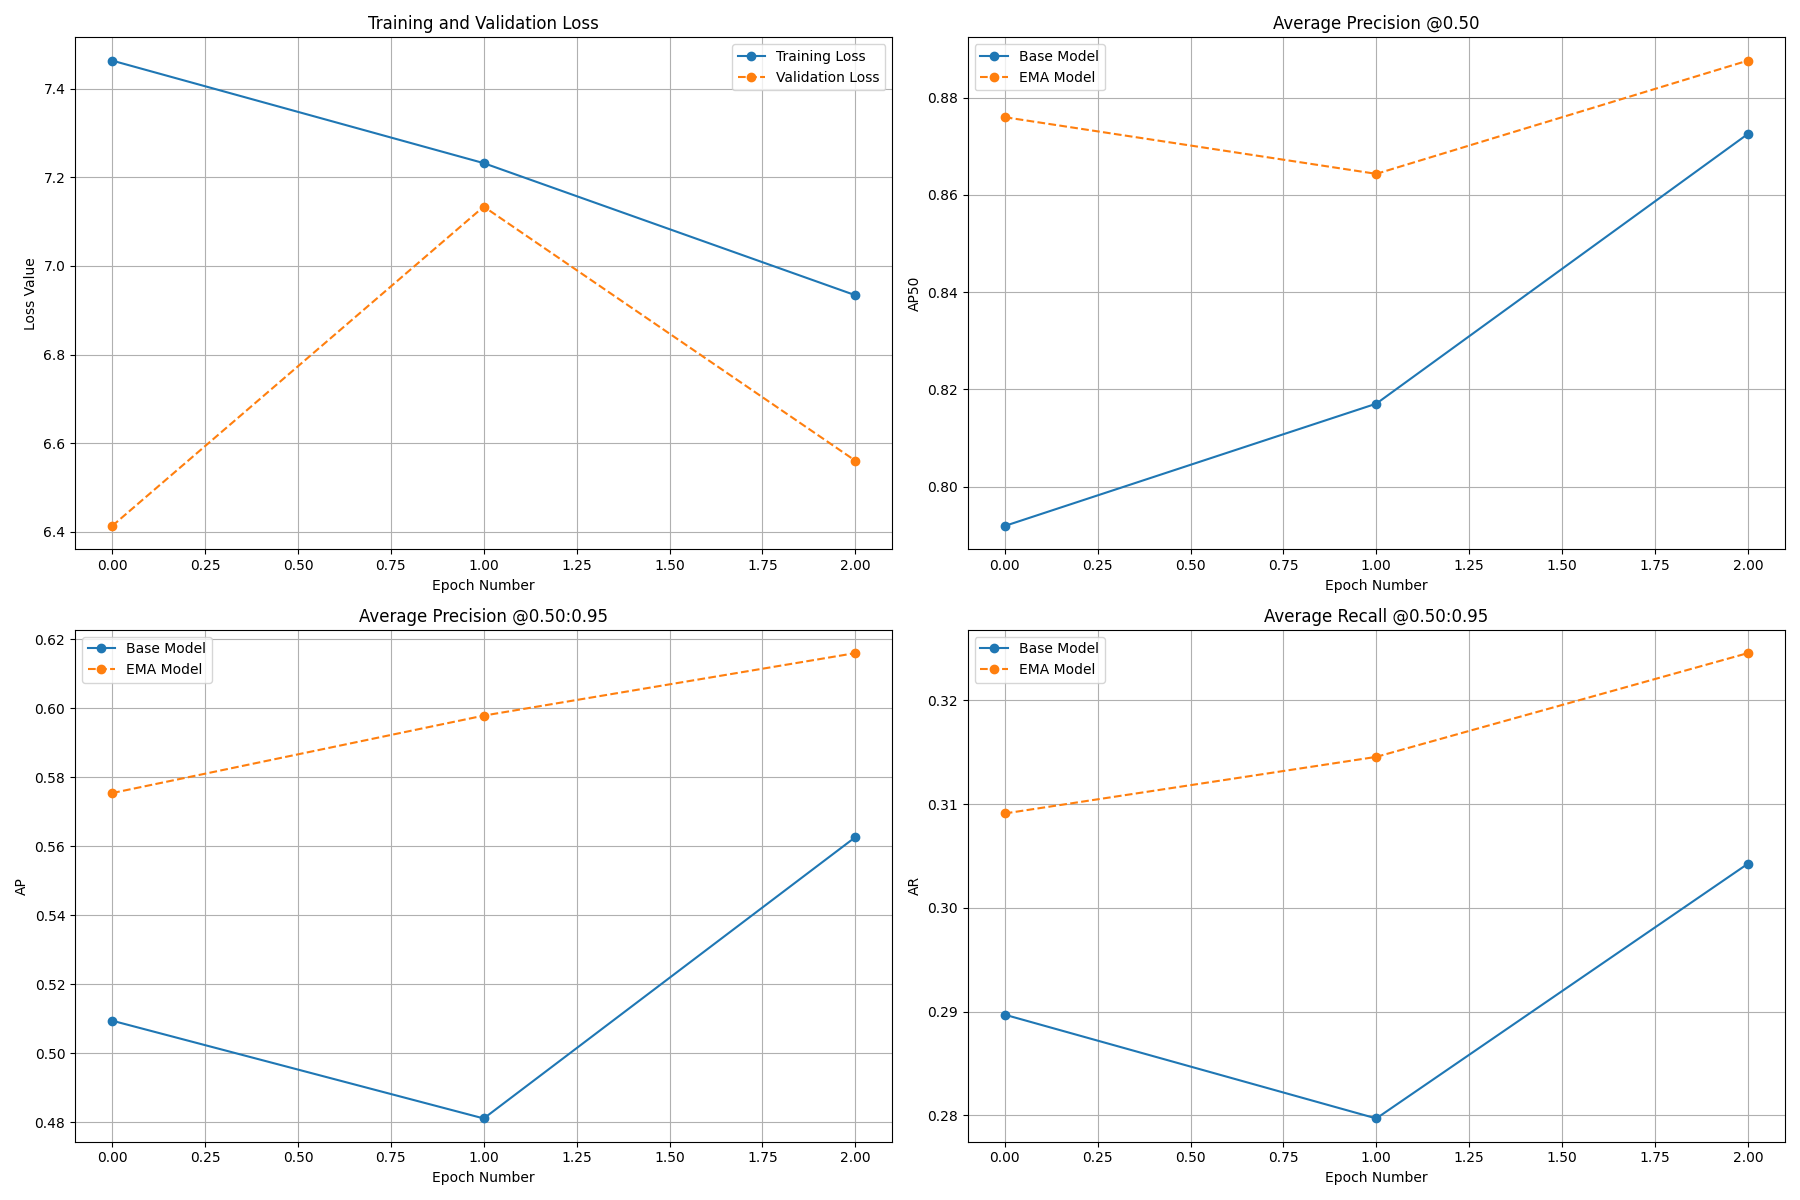

In [5]:
Image.open("output/metrics_plot.png")
# Affiche un résumé rapide du modèle
#print(model)

In [7]:
checkpoint = torch.load('output/checkpoint0059.pth', weights_only=False)
model.load_state_dict(checkpoint['model'], strict=True)

AttributeError: 'RFDETRBase' object has no attribute 'load_state_dict'

In [ ]:
import supervision as sv

ds = sv.DetectionDataset.from_coco(
    images_directory_path=os.path.join(data_dir, "Fish.v44i.coco", "test"),
    annotations_path=os.path.join(data_dir, "Fish.v44i.coco", "test","_annotations.coco.json")
)

In [ ]:
path, image, annotations = ds[53] #id de l'image à analyser
image = Image.open(path)

detections = model.predict(image, threshold=0.1)
print(detections)
print(type(detections))

#text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)
#thickness = sv.calculate_optimal_line_thickness(resolution_wh=image.size)

bbox_annotator = sv.BoxAnnotator()#thickness=thickness)
label_annotator = sv.LabelAnnotator(
    text_color=sv.Color.BLACK,
    smart_position=True)

annotations_labels = [
    f"{ds.classes[class_id]}"
    for class_id
    in annotations.class_id
]

detections_labels = [
    f"{ds.classes[class_id]} {confidence:.2f}"
    for class_id, confidence
    in zip(detections.class_id, detections.confidence)
]

annotation_image = image.copy()
annotation_image = bbox_annotator.annotate(annotation_image, annotations)
annotation_image = label_annotator.annotate(annotation_image, annotations, annotations_labels)

detections_image = image.copy()
detections_image = bbox_annotator.annotate(detections_image, detections)
detections_image = label_annotator.annotate(detections_image, detections, detections_labels)

sv.plot_images_grid(images=[annotation_image, detections_image], grid_size=(1, 2), titles=["Annotation", "Detection"])